# Gillespie Simulation for Life Scientists

This notebook describes Gillespie simulation methods and provides an interactive sample wherein you can play with a simple Gillespie simulation. For background on Gillespie simulation, I'd recommend reading the [Wikipedia page](https://en.wikipedia.org/wiki/Gillespie_algorithm) for a short explanation. For a more thorough explanation on why this approach is preferable to modeling using deterministic ODEs, see [the original manuscript published by Daniel Gillespie](http://pubs.acs.org/doi/10.1021/j100540a008). This notebook is intended to make sense to readers familiar with high school math, a general understanding of [exponential](https://en.wikipedia.org/wiki/Exponential_distribution) and [uniform](https://en.wikipedia.org/wiki/Uniform_distribution) probability distributions, and a few shreds of hazily remembered calculus (the general idea of derivatives).

The code run in this notebook is written using [Python 3.6](https://www.python.org/downloads/) and requires [matplotlib](https://matplotlib.org/users/installing.html), [jupyter](http://jupyter.org/install), and [numpy](https://docs.scipy.org/doc/numpy-1.10.1/user/install.html).

In [19]:
# set up the python environment
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import sys
from IPython.display import Latex
sys.path.append(os.getcwd())
from gillespie_python_helpers import *

# Why use the Gillespie simulation approach instead of modeling with ODEs?

Naïvely, we may think that we could just model turnover with equations explaining each synthesis/turnover event, but here we'll explain why that's not ideal. If you want to go straight to how Gillespie simulation works, you can skip this.

For example purposes, we'll be working with a simple one-state synthesis and decay process where molecules are produced at a constant rate ___k<sub>synth</sub>___, and decay at a constant rate ___k<sub>decay</sub>___:  

<img src="etc/schematic.png" alt="Drawing" style="width: 400px;"/>  

Note that both of these processes are irreversible in our simple case, though it's possible to set up a simulation where they are reversible.

We may think it's best to take time steps of length $\tau$ and then see how many of each event likely took place, but this isn't ideal: the expected number of molecules ___n<sub>decay</sub>___ that decay in time $\tau$ is $$n_{decay,\Delta t=\tau} = Nk_{decay}\tau$$

where ___N___ is the number of molecules in existence. If nothing else influenced the number of molecules ___N___ in the population other than decay, we could calculate $n_{decay,\Delta t=\tau}$ easily with a differential equation. However, when an unrelated stochastic process is adding more molecules to ___N___ in that same timeframe, this becomes complicated - even in this very simple system!

A simpler approach is to use all of the rate constants to determine the time until the next event takes place, _whatever it may be_, and _then_ determine what event took place. That's what the Gillespie approach does.

# Gillespie simulation summary

In this approach, rather than taking time steps of a defined length and trying to determine how many events of each type took place, we 1. simulate how long until the next event and 2. determine which event took place. See below for a mathematical description of how we do this.

### 1. Time between events
Let's begin with a single process, such as decay of an existing population of molecules:  

<img src="etc/schematic_2.png" alt="Drawing" style="width: 275px;"/>  

The decay rate equation for this process is $$\frac{dN}{dt} = -k_{decay}*N$$ and therefore $$N(t) = N_{0}e^{-k_{decay}t}$$

meaning that _time steps between decay events are exponentially distributed._ We'll see why this is important in a moment.

If we have multiple decay (or creation) processes influencing the abundance of one population, such as in this model:

<img src="etc/schematic.png" alt="Drawing" style="width: 400px;"/>  

then the decay rate corresponds to the sum of all of the different processes that influence ___N___: $$\frac{dN}{dt} = -k_{decay}*N + k_{synth}$$ in this case. Skipping over some calculus, this means that the levels of ___N___ over time is: $$N(t) = N_{0}e^{-ln(N)*k_{decay} + k{synth}}$$ The details of this equation aren't important, but what is important is that the time steps between decay correspond to _the sum of the different rate constants times the size of the population they are acting on_. 

Because this is a stochastic process (there's no set, deterministic time in between new synthesis or decay events occurring), we can simulate the time between events by drawing from a probability distribution. This probability distribution needs to reflect the likelihood of an event taking place at any given moment in the model, which based on the equations above (and skipping over a bit more calculus; see [this article](https://people.maths.ox.ac.uk/erban/Education/StochReacDiff.pdf) for a mathematically rigorous explainer), is exponentially distributed based on the sum of the various different event rates. Therefore, we draw $\tau$ from an exponential distribution  

$$p(\tau) = \lambda e^{-\lambda \tau} \text{, where } \lambda = \sum_{i}N_{i}k_{i}$$ 
 
using a random exponential number generator.

### 2. Determining which event took place

Once we have determined when the next step will take place, we need to determine which process occurred: in this case, was a new molecule added, or was an existing molecule eliminated? The likelihood that each of these events took place is proportional to the fraction of $\lambda$ above that each event corresponds to. In mathematical terms,  
$$p(i) = \frac{N_{i}k_{i}}{\sum_{i}N_{i}k_{i}}$$  
We can easily tell the computer to pick which event took place by randomly drawing one of the events based on these probabilities - see the code below for an example of how to do so.


Now that we have defined the two steps, we're ready to set up the simulation.




# Setting up Gillespie simulations

There are four key steps to performing these simulations:

### 1. Initialize the simulation

We need to establish initial conditions for the simulation. For our purposes, let's imagine we want to simulate the age of the population of molecules present in the simple synthesis and decay process described above (note: this is very similar to the one-state simulation performed for Figure 5B [here](https://elifesciences.org/articles/28507)). Depending upon your needs, you may want to start at steady state or in some other condition (_e.g._ with no molecules present at t=0 to monitor accumulation in a new vessel). If you want to use a non-steady-state condition, you can just set it up yourself; if you plan to start from steady state, you need to figure out what that is. You can do so one of two ways: by mathematically deriving the steady state, or by initializing your simulation in a non-steady-state condition and allow it to run until it reaches steady state. The former requires less computational time, the latter requires less mathematical prowess. Here, we'll go through how to simulate to reach steady state by starting with the "empty vessel" state.  

The cell below runs a Gillespie simulation (we'll go step-by-step through pseudocode for how it works later) and spits out the number of particles, average age, and the ages of all of the particles at each timepoint. It then plots some useful statistics.

Text(0,0.5,'Fraction of the population')

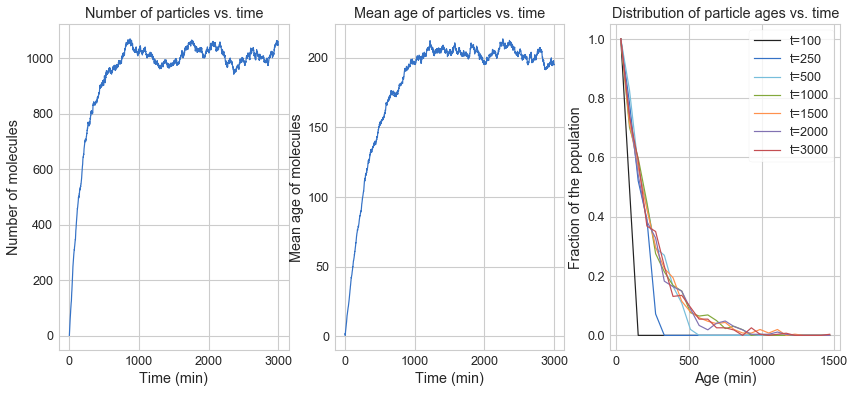

In [46]:
ct_checkpoints, age_checkpoints, sim_series = one_state_simulation(5,0.005, t_final=3000, return_sim=True)

hists = np.empty(shape=(7, 25))
tpts = (100,250,500,1000,1500,2000,2999)
for i in range(0,7):
    hists[i, :], edges = np.histogram(sim_series[tpts[i]], bins=25, range=(0,1500))
    hists[i, :] = hists[i, :]/np.amax(hists[i,:])  # normalize to 1

edges = edges+(edges[1]-edges[0])/2
edges = edges[:-1]
fig, (ct_plot, age_plot, age_dist) = plt.subplots(1,3)
fig.set_figwidth(14)
fig.set_figheight(6)
ct_plot.plot(ct_checkpoints)
ct_plot.set_title('Number of particles vs. time')
ct_plot.set_xlabel('Time (min)')
ct_plot.set_ylabel('Number of molecules')
age_plot.plot(age_checkpoints)
age_plot.set_title('Mean age of particles vs. time')
age_plot.set_xlabel('Time (min)')
age_plot.set_ylabel('Mean age of molecules')
age_dist.plot(edges, hists[0,:], 'k-', label='t=100')
age_dist.plot(edges, hists[1,:], 'b-', label='t=250')
age_dist.plot(edges, hists[2,:], 'c-', label='t=500')
age_dist.plot(edges, hists[3,:], 'g-', label='t=1000')
age_dist.plot(edges, hists[4,:], 'y-', label='t=1500')
age_dist.plot(edges, hists[5,:], 'm-', label='t=2000')
age_dist.plot(edges, hists[6,:], 'r-', label='t=3000')
age_dist.legend(loc="upper right", bbox_to_anchor=[1, 1],
           ncol=1)
age_dist.set_title('Distribution of particle ages vs. time')
age_dist.set_xlabel('Age (min)')
age_dist.set_ylabel('Fraction of the population')

We can clean this up by performing multiple simulations and then averaging:

In [49]:
ct_arr = np.empty(shape=(50,2000))
age_arr = np.empty(shape=(50,2000))
for i in range(0,50):
    ct_arr[i, :], age_arr[i, :] = one_state_simulation(5,0.005, t_final=2000, return_sim=False)
    print('round ' + str(i) + ' complete')


           
    

round 0 complete
round 1 complete
round 2 complete
round 3 complete
round 4 complete
round 5 complete
round 6 complete
round 7 complete
round 8 complete
round 9 complete
round 10 complete
round 11 complete
round 12 complete
round 13 complete
round 14 complete
round 15 complete
round 16 complete
round 17 complete
round 18 complete
round 19 complete
round 20 complete
round 21 complete
round 22 complete
round 23 complete
round 24 complete
round 25 complete
round 26 complete
round 27 complete
round 28 complete
round 29 complete
round 30 complete
round 31 complete
round 32 complete
round 33 complete
round 34 complete
round 35 complete
round 36 complete
round 37 complete
round 38 complete
round 39 complete
round 40 complete
round 41 complete
round 42 complete
round 43 complete
round 44 complete
round 45 complete
round 46 complete
round 47 complete
round 48 complete
round 49 complete


Text(0,0.5,'Mean age of molecules')

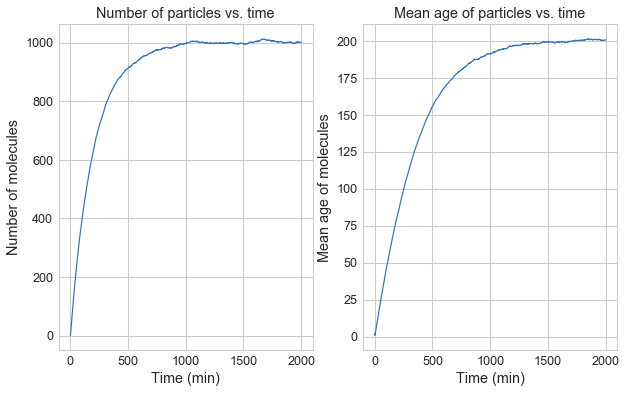

In [50]:
ct_means = np.mean(ct_arr, axis=0)
age_means = np.mean(age_arr, axis=0)

fig, (ct_plot, age_plot) = plt.subplots(1,2)
fig.set_figwidth(10)
fig.set_figheight(6)
ct_plot.plot(ct_means)
ct_plot.set_title('Number of particles vs. time')
ct_plot.set_xlabel('Time (min)')
ct_plot.set_ylabel('Number of molecules')
age_plot.plot(age_means)
age_plot.set_title('Mean age of particles vs. time')
age_plot.set_xlabel('Time (min)')
age_plot.set_ylabel('Mean age of molecules')

Based on the earlier histograms, we can see that at steady state the population has exponentially distributed age. The constant for this exponential distribution is $k_{decay}$ (see [Wikipedia](https://en.wikipedia.org/wiki/Exponential_decay) for derivation). We can therefore initialize at steady state by drawing ages from this exponential distribution and setting $k_{synth} = N_{0}*k_{decay}$. In this case, we should expect to see little to no change over the course of the simulation if we keep $k_{synth}$ and $k_{decay}$ at their steady state values.

(0, 225)

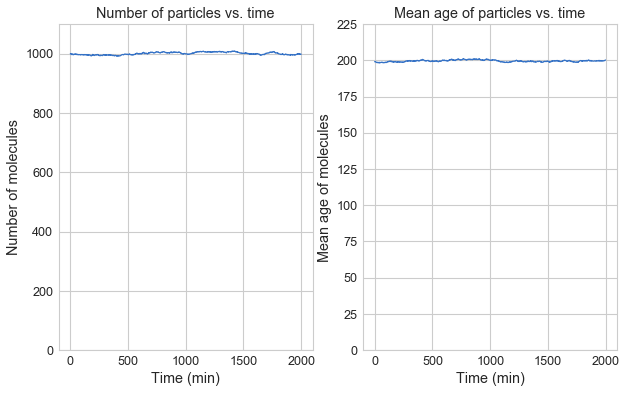

In [53]:
ct_arr = np.empty(shape=(50,2000))
age_arr = np.empty(shape=(50,2000))
for i in range(0,50):
    start_arr = np.random.exponential(scale=1/0.005, size=1000)  # np.random.exponential takes scale=1/lambda instead of lambda
    ct_arr[i, :], age_arr[i, :] = one_state_simulation(5, 0.005, sim_arr=start_arr, t_final=2000, return_sim=False)

ct_means = np.mean(ct_arr, axis=0)
age_means = np.mean(age_arr, axis=0)

fig, (ct_plot, age_plot) = plt.subplots(1,2)
fig.set_figwidth(10)
fig.set_figheight(6)
ct_plot.plot(ct_means)
ct_plot.set_title('Number of particles vs. time')
ct_plot.set_xlabel('Time (min)')
ct_plot.set_ylabel('Number of molecules')
ct_plot.set_ylim([0,1100])
age_plot.plot(age_means)
age_plot.set_title('Mean age of particles vs. time')
age_plot.set_xlabel('Time (min)')
age_plot.set_ylabel('Mean age of molecules')
age_plot.set_ylim([0,225])

Now, onto how we perform the updating steps within this simulation.

### 2. Determine time to next event
As mentioned earlier,  
$$p(\tau) = \lambda e^{-\lambda \tau} \text{, where } \lambda = \sum_{i}N_{i}k_{i}$$
For the purposes of this simulation, this means that  
  
$$p(\tau) = (k_{synth}+N*k_{decay})e^{-(k_{synth}+N*k_{decay})\tau}$$  
Therefore, to calculate $\tau$, all we have to do is add up $N_{i}k_{i}$ for for each input, then plug that number into a random exponential number generator. For $k_{synth}$, _N_ is just 1 for the purposes of this simulation - in this simple case, we never change the input rate (though you could!). By contrast, the number of molecules subject to decay changes after every step, so $N*k_{decay}$ must be re-calculated for each step. We therefore perform the following process in each round:
___
`# set up variables`  
`age_vector = [0.25, 1, 300, 150, ...]  # vector for ages of particles`  
`kdecay = 0.005  # set up decay rate constant`  
`ksynth = 5  # set up synthesis rate constant`  
  
`get_tau = function(age_vector, kdecay, ksynth):`  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`N = length(age_vector)  # get the number of objects subject to kdecay`  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`lambda = N\*kdecay + 1\*ksynth`  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`tau = get_random_exponential(lambda)  # perform random draw from exponential`   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`return tau`  
___

We can repeat this every time we need to calculate $\tau$ (that is, every timestep).

### 3. Determine which event took place and update state

As mentioned earlier, the likelihood of a given event is  
$$p(i) = \frac{N_{i}k_{i}}{\sum_{i}N_{i}k_{i}}$$  
Written out, this just means that the probability of an event (addition of a new molecule or decay of an existing molecule, in this case) is the fraction of all of the $N*k$ that this specific event corresponds to. When we initialized with no particles present earlier, $N*k_{decay}$ was very small (because _N_ was very small), and therefore nearly all events were new addition events. By contrast, at steady state, these probabilities are roughly equal (hence why _N_ averages to approximately 1000 when $k_{synth}$ is 1000x larger than $k_{decay}$ in the examples above). To distinguish between these cases, we simply draw from a uniform distribution (equal probability everywhere) and assign appropriate fractions of the distribution to each possible outcome.\* See the pseudo-code below.
___
`# set up the variables`  
`age_vector = [0.25, 1, 300, 150, ...]  # vector for ages of particles`  
`kdecay = 0.005  # set up decay rate constant`  
`ksynth = 5  # set up synthesis rate constant`  
  
`get_event = function(age_vector, kdecay, ksynth):`  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`N = length(age_vector)  # get the number of objects subject to kdecay`  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`p_total = N\*kdecay + 1\*ksynth  # this is equivalent to the un-normalized probability mass`  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`p_synth = ksynth/p_total  # get fraction of p_total corresponding to synthesis`   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`event_draw = get_random_uniform()  # perform random draw from [0,1] uniform distribution`   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`if event_draw < p_synth:  # if the drawn value falls within the p_synth part of the distribution`  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`append 0 to age_vector  # add a new molecule`    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`else remove random element from age_vector`  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`return age_vector`  
___

This can be extended for more than two possible outcomes: we just need to split the uniform distribution more ways.

\* in the actual code implementing this simulation, I used a binomial distribution instead of splitting a uniform thus because it's faster. Note that when there are only two possible outcomes, this is the same thing.


### Putting it all together
To run this simulation, we simply need to repeat the two steps above, keeping track of the time and the ages of all of the molecules present, until we hit our desired end time. A simplified, pseudo-coded implementation of this is shown below; for a full implementation using Python, see `gillespie_python_helpers.py` in this directory.

__Pseudo-code implementation of a Gillespie Simulation__
___
`# before we start the simulation, initialize the variables`  
`kdecay = 0.005  # set up decay rate constant`  
`ksynth = 5  # set up synthesis rate constant`  
`# in this case, we'll start at steady state by initializing ages using the exponential distribution`  
`age_vector = get_random_exponential(rate=kdecay, times=1000) # vector of values for ages of particles`  
`t = 0  # initialize the time at 0`  
`end_time = 3000  # initialize end time at 3000 minutes (or whatever you like)`  

`while t < end_time:`
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`tau = get_tau(age_vector, kdecay, ksynth)  # see function definition earlier`  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`age_vector = age_vector + tau  # age all of the molecules the time step length`
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`t = t + tau  # update time`
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`age_vector = get_event(age_vector, kdecay, ksynth)  # see function definition earlier`  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`save(age_vector, t)  # record the age vector and timepoint after each iteration. See python code for an alternative`  
___
That's really all there is to it! 14 lines of pseudo-code (or less than 100 lines of Python code, include 40 lines of documentation). Without much difficulty this can be extended to include distinct decay rates for distinct populations of molecules to monitor more complex behavior (see Figure 5B of our paper [here](https://elifesciences.org/articles/28507) for an example). Below are a few more examples of analyses that you can do even without adding any bells and whistles to the model. Questions or comments? Contact me at nicholas.r.weir@gmail.com.

# Examples

### 1. Monitoring population levels and age after increasing _k<sub>synth</sub>_ (for example, by inducing overexpression)

For this example, we'll initialize at steady state with $k_{synth} = N*k_{decay}$, but from the beginning of the simulation, the synthesis rate will be 10x the steady state levels. Note the striking dip in mean age as the flux of new molecules increases at early timepoints, which then re-stabilizes as the population reaches the new steady state size.

Text(0,0.5,'Mean age of molecules')

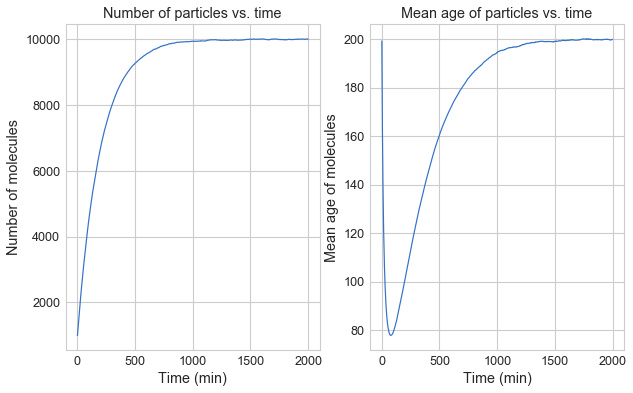

In [54]:
ct_arr = np.empty(shape=(50,2000))
age_arr = np.empty(shape=(50,2000))
for i in range(0,50):
    start_arr = np.random.exponential(scale=1/0.005, size=1000)  # np.random.exponential takes scale=1/lambda instead of lambda
    ct_arr[i, :], age_arr[i, :] = one_state_simulation(50, 0.005, sim_arr=start_arr, t_final=2000, return_sim=False)

ct_means = np.mean(ct_arr, axis=0)
age_means = np.mean(age_arr, axis=0)

fig, (ct_plot, age_plot) = plt.subplots(1,2)
fig.set_figwidth(10)
fig.set_figheight(6)
ct_plot.plot(ct_means)
ct_plot.set_title('Number of particles vs. time')
ct_plot.set_xlabel('Time (min)')
ct_plot.set_ylabel('Number of molecules')
age_plot.plot(age_means)
age_plot.set_title('Mean age of particles vs. time')
age_plot.set_xlabel('Time (min)')
age_plot.set_ylabel('Mean age of molecules')

### 2. Monitoring population age after enhancing turnover (increasing _k<sub>decay</sub>_)

Similar to what is shown above, we'll begin at steady state and then increase $k_{decay}$ 20-fold at the beginning of the simulation. The leads to a rapid reduction of both the population size and its age.

Text(0,0.5,'Mean age of molecules')

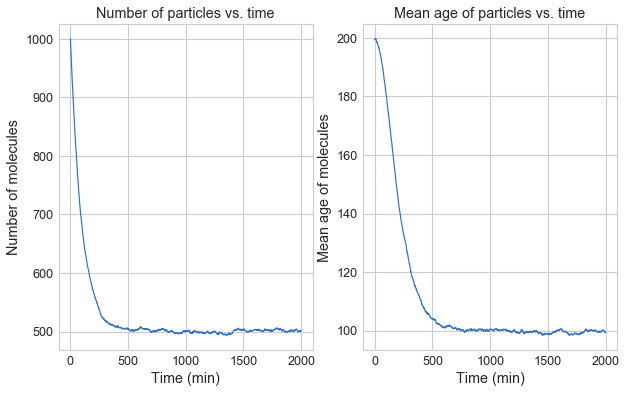

In [55]:
ct_arr = np.empty(shape=(50,2000))
age_arr = np.empty(shape=(50,2000))
for i in range(0,50):
    start_arr = np.random.exponential(scale=1/0.005, size=1000)  # np.random.exponential takes scale=1/lambda instead of lambda
    ct_arr[i, :], age_arr[i, :] = one_state_simulation(5, 0.01, sim_arr=start_arr, t_final=2000, return_sim=False)

ct_means = np.mean(ct_arr, axis=0)
age_means = np.mean(age_arr, axis=0)

fig, (ct_plot, age_plot) = plt.subplots(1,2)
fig.set_figwidth(10)
fig.set_figheight(6)
ct_plot.plot(ct_means)
ct_plot.set_title('Number of particles vs. time')
ct_plot.set_xlabel('Time (min)')
ct_plot.set_ylabel('Number of molecules')
age_plot.plot(age_means)
age_plot.set_title('Mean age of particles vs. time')
age_plot.set_xlabel('Time (min)')
age_plot.set_ylabel('Mean age of molecules')

# Play with the simulations yourself!

In the code below, edit the variables at the very top of the cell and then run it to monitor simulation outputs. Don't touch the actual simulation and plotting code indicated! 

## Single simulation

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Text(0,0.5,'Mean age of molecules')

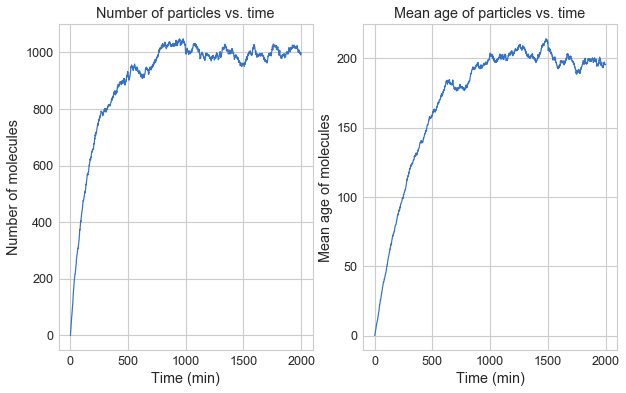

In [59]:
## CHANGE THESE VALUES ##

k_synth = 5
k_decay = 0.005
simulation_length = 2000  # simulated time in minutes
starting_number_of_particles = 0  # set to zero for empty vessel; set to k_synth/k_decay for steady state


####################################################################################################################################
################################# DON'T TOUCH ANYTHING BELOW HERE!! ################################################################
####################################################################################################################################


start_arr = np.random.exponential(scale=1/0.005, size=starting_number_of_particles)  # np.random.exponential takes scale=1/lambda instead of lambda
ct_arr, age_arr = one_state_simulation(k_synth, k_decay, sim_arr=start_arr, t_final=simulation_length, return_sim=False)

fig, (ct_plot, age_plot) = plt.subplots(1,2)
fig.set_figwidth(10)
fig.set_figheight(6)
ct_plot.plot(ct_arr)
ct_plot.set_title('Number of particles vs. time')
ct_plot.set_xlabel('Time (min)')
ct_plot.set_ylabel('Number of molecules')
age_plot.plot(age_arr)
age_plot.set_title('Mean age of particles vs. time')
age_plot.set_xlabel('Time (min)')
age_plot.set_ylabel('Mean age of molecules')

## Averaged multiple simulation
This takes a while to run, be patient!

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Text(0,0.5,'Mean age of molecules')

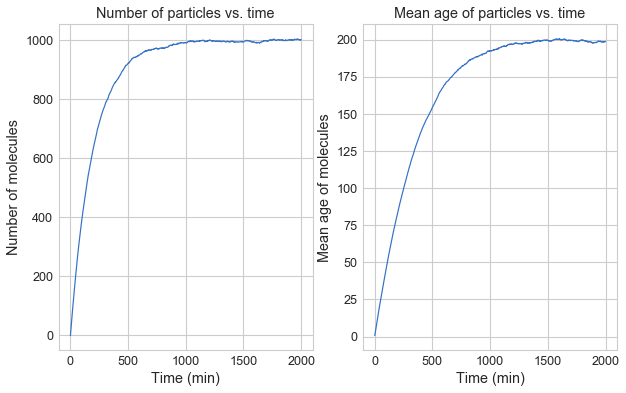

In [60]:
## CHANGE THESE VALUES ##

k_synth = 5
k_decay = 0.005
simulation_length = 2000  # simulated time in minutes
starting_number_of_particles = 0  # set to zero for empty vessel; set to k_synth/k_decay for steady state


####################################################################################################################################
################################# DON'T TOUCH ANYTHING BELOW HERE!! ################################################################
####################################################################################################################################

ct_arr = np.empty(shape=(50,simulation_length))
age_arr = np.empty(shape=(50,simulation_length))

for i in range(0,50):
    start_arr = np.random.exponential(scale=1/0.005, size=starting_number_of_particles)  # np.random.exponential takes scale=1/lambda instead of lambda
    ct_arr[i, :], age_arr[i, :] = one_state_simulation(k_synth, k_decay, sim_arr=start_arr, t_final=simulation_length, return_sim=False)

ct_means = np.mean(ct_arr, axis=0)
age_means = np.mean(age_arr, axis=0)

fig, (ct_plot, age_plot) = plt.subplots(1,2)
fig.set_figwidth(10)
fig.set_figheight(6)
ct_plot.plot(ct_means)
ct_plot.set_title('Number of particles vs. time')
ct_plot.set_xlabel('Time (min)')
ct_plot.set_ylabel('Number of molecules')
age_plot.plot(age_means)
age_plot.set_title('Mean age of particles vs. time')
age_plot.set_xlabel('Time (min)')
age_plot.set_ylabel('Mean age of molecules')